In [310]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
#from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import matplotlib.pyplot as plt

In [311]:
from sklearn.metrics import make_scorer
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [312]:
df_train = pd.read_csv('../datasets/vkitti_kitti_train.csv')
df_valid = pd.read_csv('../datasets/vkitti_kitti_valid.csv')
df_test = pd.read_csv('../datasets/vkitti_kitti_test.csv')

In [313]:
train = df_train.drop(['filename', 'class', 'weather','angle'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather','angle'], axis=1)
test = df_test.drop(['filename', 'class', 'weather','angle'], axis=1)

In [314]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [315]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

In [316]:
X_train_scale = scalerX.transform(X_train)
#y_train_scale = scalery.transform(y_train)

X_valid_scale = scalerX.transform(X_valid)
#y_valid_scale = scalery.transform(y_valid)

X_test_scale = scalerX.transform(X_test)
#y_test_scale = scalery.transform(y_test)

In [204]:
#['xmin', 'ymin', 'xmax', 'ymax', 'zloc', 'depth_mean', 'depth_min','width', 'height']

In [63]:
os.makedirs('./weights', exist_ok=True)

In [320]:
#텐서화
X_train = torch.FloatTensor(X_train_scale)
y_train = torch.FloatTensor(y_train.values)

X_valid = torch.FloatTensor(X_valid_scale)
y_valid = torch.FloatTensor(y_valid.values)

X_test = torch.FloatTensor(X_test_scale)
y_test = torch.FloatTensor(y_test.values)

In [321]:
class Zloc_Estimaotor(nn.Module):
    def __init__(self):
        super().__init__()
        #Layer
        layersize=[16,32,64,32,16,8,2]
        layerlist= []
        n_in=10
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(0.2))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        layerlist.append(nn.Sigmoid())
        
        self.layers=nn.Sequential(*layerlist)
        
    def forward(self, x):
        out= self.layers(x)
        return out

In [322]:
# Function to save the model 
def saveModel(model, path): 
    torch.save(model.state_dict(), path) 

In [323]:
def train_model(model, train_dataloader, valid_dataloader, loss_fn, path, lr=1e-3, batch_size=256, epochs=100, validate=False):
    param_lrs = [{'params':param, 'lr':lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr) #weighted decay 설정하여고고
  
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    best_rmse = np.Inf
    print("Begin training...") 
    res_train = []
    res_valid = []
    res_rmse = []
    for epoch in range(1, epochs+1): 
    running_train_loss = 0.0 
    running_rmse = 0.0 
    running_val_loss = 0.0 
    total = 0 

    for batch_ind, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        optimizer.zero_grad()
        pred = model.forward(x_train)
        train_loss = loss_fn(pred, y_train)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

    train_loss_value = running_train_loss/len(train_dataloader)
    
    with torch.no_grad(): 
      #model.eval() 
      for data in valid_dataloader: 
        inputs, outputs = data 
        predicted_outputs = model(inputs) 
        val_loss = loss_fn(predicted_outputs, outputs) 
      
        # The label with the highest value will be our prediction 
        running_val_loss += val_loss.item()  
        total += 1
        rmse = mean_squared_error(outputs, predicted_outputs)
        running_rmse += rmse

    # Calculate validation loss value 
    val_loss_value = running_val_loss/len(valid_dataloader)  
    rmse = (running_rmse / total)**0.5

    if rmse < best_rmse:
        saveModel(model, path)
        best_rmse = rmse
    
    # Print the statistics of the epoch 
    print('Epoch {0}/{1} - loss: {2:.4f} / val_loss: {3:.4f} - RMSE: {4:.4f}'.format(epoch, epochs, train_loss_value, val_loss_value, rmse))
    res_train.append(train_loss_value)
    res_valid.append(val_loss_value)
    res_rmse.append(rmse)
    return [res_train, res_valid, res_rmse]

In [324]:
def predict(test_dataloader, path): 
    # Load the model that we saved at the end of the training loop 
    model = Zloc_Estimaotor()
    model.load_state_dict(torch.load(path)) 
     
    running_rmse = 0 
    total = 0 
    pred = []
 
    with torch.no_grad(): 
        model.eval()
        for data in test_dataloader: 
            inputs, outputs = data 
            inputs=inputs.unsqueeze(0)
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs) 
            pred.append(float(predicted_outputs))
            total += 1
        rmse = mean_squared_error(outputs, predicted_outputs)
        running_rmse += rmse

        print('RMSE:',(running_rmse / total)**0.5)
        return pred

In [325]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [327]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear): # nn.Linear에 있는 가중치에만 적용
        init.kaiming_uniform_(m.weight.data) # He initialization

model = Zloc_Estimaotor()
model.apply(weight_init) # 가중치 초깃값 설정
loss_func = nn.MSELoss()
path = ("weights/ZLE_03.pth")

In [328]:
model

DistanceEstimator(
  (activation): ReLU()
  (fc1): Linear(in_features=10, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=1, bias=True)
)

In [329]:
res = train_model(model, train_dataloader, valid_dataloader, loss_func, path)

Begin training...
Epoch 1/100 - loss: 658.2317 / val_loss: 700.3019 - RMSE: 26.4632
Epoch 2/100 - loss: 553.6178 / val_loss: 684.9234 - RMSE: 26.1710
Epoch 3/100 - loss: 543.5317 / val_loss: 671.5257 - RMSE: 25.9138
Epoch 4/100 - loss: 533.6524 / val_loss: 658.7731 - RMSE: 25.6666
Epoch 5/100 - loss: 525.0382 / val_loss: 647.1733 - RMSE: 25.4396
Epoch 6/100 - loss: 516.8124 / val_loss: 638.3615 - RMSE: 25.2658
Epoch 7/100 - loss: 510.0521 / val_loss: 629.8114 - RMSE: 25.0960
Epoch 8/100 - loss: 504.2219 / val_loss: 623.2377 - RMSE: 24.9647
Epoch 9/100 - loss: 499.1411 / val_loss: 616.9157 - RMSE: 24.8378
Epoch 10/100 - loss: 494.4807 / val_loss: 609.3350 - RMSE: 24.6847
Epoch 11/100 - loss: 490.0131 / val_loss: 605.9001 - RMSE: 24.6150
Epoch 12/100 - loss: 485.6917 / val_loss: 600.7133 - RMSE: 24.5095
Epoch 13/100 - loss: 481.8658 / val_loss: 595.3348 - RMSE: 24.3995
Epoch 14/100 - loss: 477.0509 / val_loss: 588.2079 - RMSE: 24.2530
Epoch 15/100 - loss: 472.2077 / val_loss: 581.4943 - 

In [330]:
res_train, res_valid, rmse = res

In [271]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [333]:
pred = predict(test_dataset, path)

RMSE: 37.22647792851735


In [285]:
res_df = pd.DataFrame()
res_df['actual_scale'] = np.ravel(y_test)
res_df['pred_scale'] = pred
#res_df['actual'] = scalery.inverse_transform(np.array(res_df.actual_scale).reshape(-1,1))
#res_df['pred'] = scalery.inverse_transform(np.array(res_df.pred_scale).reshape(-1,1))

In [302]:
res_df

,actual_scale,pred_scale,actual,pred
0,-0.761834,-0.790178,7.900000,7.027871
1,-0.520994,-0.474861,15.310440,16.729897
2,0.566771,0.331421,48.779999,41.538489
3,-0.598357,-0.530478,12.930040,15.018620
4,-0.359028,-0.330449,20.293970,21.173337
...,...,...,...,...
6621,-0.437483,-0.392130,17.879999,19.275468
6622,-0.637033,-0.612840,11.740000,12.484419
6623,0.517730,0.446391,47.271049,45.076014
6624,-0.625983,-0.615325,12.080000,12.407936


In [274]:
mean_squared_error(res_df.actual_scale, res_df.pred_scale)**0.5

0.5668207555474264

In [275]:
mean_squared_error(res_df.actual, res_df.pred)**0.5

17.44057868781602

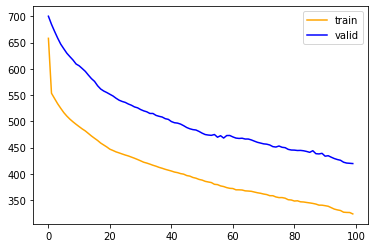

In [334]:
plt.plot(res_train, color='orange', label='train')
plt.plot(res_valid, color='blue', label='valid')
plt.legend()
plt.show()

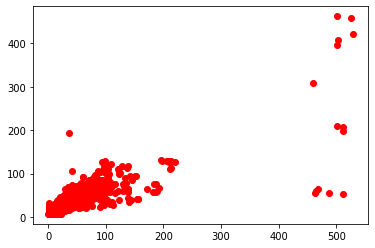

In [294]:
plt.scatter(res_df.actual, res_df.pred, color='red') 
plt.show()

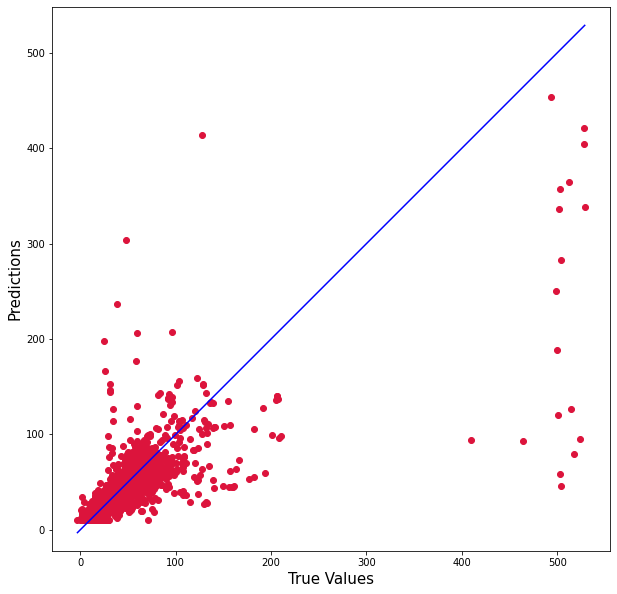

In [335]:
plt.figure(figsize=(10,10))
plt.scatter(res_df.actual_scale, res_df.pred_scale, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(res_df.pred_scale), max(res_df.actual_scale))
p2 = min(min(res_df.pred_scale), min(res_df.actual_scale))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()